In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage.interpolation import shift
from matplotlib.patches import Polygon
import matplotlib as mpl
import pandas as pd


import seaborn as sns
import statsmodels.formula.api as smf
from sklearn import preprocessing
from sklearn.preprocessing import minmax_scale,scale,normalize

from numpy import polyder
import skimage as sk
import math

import scipy as sc
from scipy import interpolate 


from skimage import measure 
from skimage import io
from skimage import feature
from skimage import filters

from skimage.morphology import medial_axis, skeletonize, skeletonize_3d
from skimage.morphology import skeletonize_3d
from skimage import data
from skimage.util import invert

C:\Users\Mackenzie\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Read in your separate csv files 

In [2]:
# read in here
_17_299 = pd.read_csv('17_299.csv')
_17_299_interp = pd.read_csv('17_299_interp.csv')
_17_299_sbox_min_max = pd.read_csv('17_299_sliceminmax.csv')



_17_291 = pd.read_csv('17_291.csv')
_17_291_interp = pd.read_csv('17_291_interp.csv')
_17_291_sbox_min_max = pd.read_csv('17_291_sliceminmax.csv')


_17_295 = pd.read_csv('17_295.csv')
_17_295_interp = pd.read_csv('17_295_interp.csv')
_17_295_sbox_min_max = pd.read_csv('17_295_sliceminmax.csv')


_18_160 = pd.read_csv('18_160.csv')
_18_160_interp = pd.read_csv('18_160_interp.csv')
_18_160_sbox_min_max = pd.read_csv('18_160_sliceminmax.csv')

In [3]:
# Could automate this step 

_17_299_sbox_min_max['case'] = '17_299'
_17_291_sbox_min_max['case'] = '17_291'
_17_295_sbox_min_max['case'] = '17_295'
_18_160_sbox_min_max['case'] = '18_160'

_17_299['case'] = '17_299'
_17_291['case'] = '17_291'
_17_295['case'] = '17_295'
_18_160['case'] = '18_160'


_17_299_interp['case'] = '17_299'
_17_291_interp['case'] = '17_291'
_17_295_interp['case'] = '17_295'
_18_160_interp['case'] = '18_160'

df_list = [_17_299,_17_291,_17_295,_18_160]
min_max_df = pd.concat([_17_299_sbox_min_max,_17_291_sbox_min_max,_17_295_sbox_min_max,_18_160_sbox_min_max])

# THESE ARE YOUR INTERPOLATION SIZES TO COMBINE ACROSS BRAINS #

In [9]:
slice_groups = min_max_df.groupby('0').groups.keys()

avg_min_max_list = []

for slices in slice_groups: 
    this_frame = min_max_df.loc[min_max_df['0'] == slices]
    lower_bound = this_frame['1'].max()
    upper_bound = this_frame['2'].min()
    
    avg_min_max_list.append((slices, lower_bound, upper_bound))
    #min_dist = this_frame.sbox_lin_dist.min()
    #max_dist = this_frame.sbox_lin_dist.max()

#avg_min_max_list

# Plot each case - Here I am using the mean centering scaling method

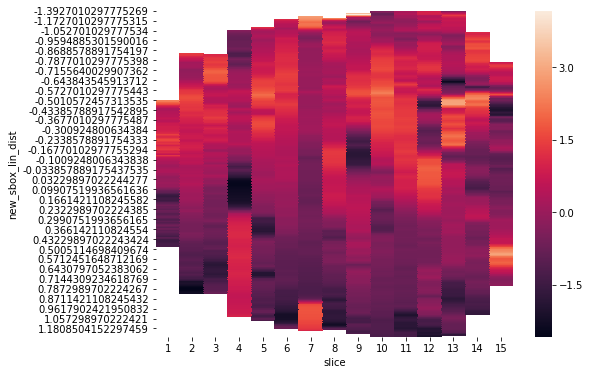

In [10]:
# Within-Slice (Mean Centering) WITH INTERPOLATION
data_pivot = _17_291_interp.pivot('new_sbox_lin_dist','slice','interped_slice_mean_center')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

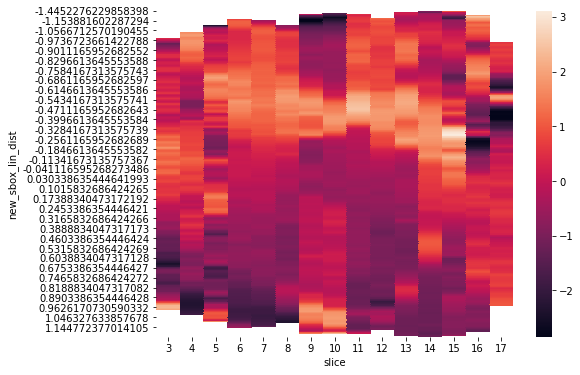

In [11]:
# Within-Slice (Mean Centering) WITH INTERPOLATION
data_pivot = _17_295_interp.pivot('new_sbox_lin_dist','slice','interped_slice_mean_center')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

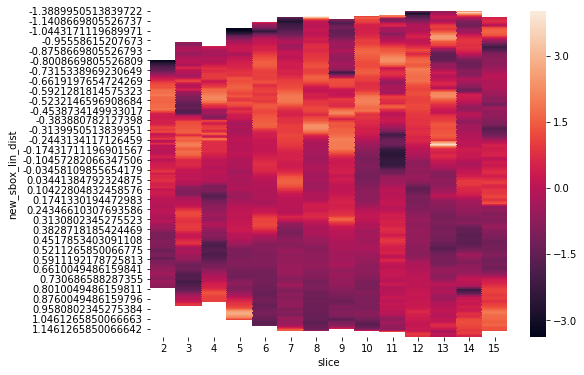

In [12]:
# Within-Slice (Mean Centering) WITH INTERPOLATION
data_pivot = _18_160_interp.pivot('new_sbox_lin_dist','slice','interped_slice_mean_center')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

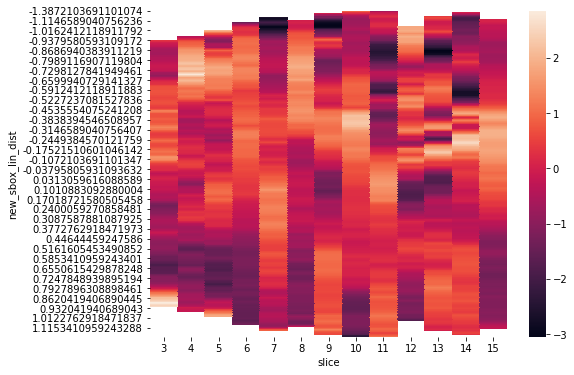

In [13]:
# Within-Slice (Mean Centering) WITH INTERPOLATION
data_pivot = _17_299_interp.pivot('new_sbox_lin_dist','slice','interped_slice_mean_center')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)

# Now interpolate each case so that sbox_lin_dist match

In [14]:
new_df_list = []

for dataframe in df_list: 

    interp_list = ['slice_mean_center','slice_z_score','slice_min_max'] #you can extend this list to other scaling methods

    min_max_list = []

    all_interped_df_list = []

    current_df = dataframe

    # Iterate through slices, selecting the range you are going to interp over 
    slice_groups = current_df.groupby('True_Order').groups.keys()
    
    for slices in slice_groups: 
        this_frame = current_df.loc[current_df['True_Order'] == slices]

        slices_new = slices - 1
    
        min_dist = avg_min_max_list[slices_new][1] #selects the lower bound for interpolation
        max_dist = avg_min_max_list[slices_new][2] #selects the upper bound for interpolation

        min_max_list.append((slices,min_dist,max_dist))
    
    
        x = this_frame.sbox_lin_dist # a list of the sbox_lin_dist
        xnew = np.arange(min_dist,(max_dist - .005), .005) # range for new interpolation values by slice
    

        new_frame = pd.DataFrame({'slice':slices,'new_sbox_lin_dist':xnew})
    
    
    
        # interpolate each column (various scaling methods)
        for column in interp_list: 
            this_column = this_frame[column] #this is where the interpolation will go? 
            this_column_name = 'interped_{0}'.format(column)
        

            y = this_column.values
        
            f = interpolate.interp1d(x,y)
        
            ynew = f(xnew)   
        

            new_frame[this_column_name] = ynew
  
    
        all_interped_df_list.append(new_frame)


    
    all_interped_dfs = pd.concat(all_interped_df_list) 
    
    new_df_list.append(all_interped_dfs)
 



In [15]:
# Now you've got all of the interpolation done, you need to add all of the dataframes together
all_brains = pd.concat(new_df_list)

# Now we have a dataframe that has n values (n=number of cases) for a single sbox_lin_dist, so we need to take the mean of those values to get one value for one sbox_lin_dist, and that becomes our heatmap value

In [16]:
means_again = []


slice_groups = all_brains.groupby('slice').groups.keys()
    
for slices in slice_groups: 
    
    this_frame = all_brains.loc[all_brains['slice'] == slices]

        
    sbox_groups = this_frame.groupby('new_sbox_lin_dist').groups.keys()
        
    mean_list = []

    for sbox in sbox_groups:
        this_sbox = this_frame.loc[this_frame['new_sbox_lin_dist'] == sbox]
        this_mean = this_sbox['interped_slice_mean_center'].mean() #NOTE WE ARE SELECTING ONLY ONE METHOD OF SCALING HERE
        
        mean_list.append((sbox,this_mean))
    
    all_mean_df = pd.DataFrame(mean_list) # this is a dataframe of all of the means for one slice
        
    all_mean_df['slice'] = slices
        
    means_again.append(all_mean_df)
    

In [17]:
aaaa = pd.concat(means_again) #bad form but my eyes were burning from too much coding at this point
aa = aaaa.rename(columns={0:'sbox', 1:'values', 2:"slice"})
aa.head()

,sbox,values,slice
0,-0.495925,2.377177,1
1,-0.490925,2.333336,1
2,-0.485925,2.243766,1
3,-0.480925,2.001477,1
4,-0.475925,1.780736,1


# And finally we can plot an average brain of P36 Sighted Monodelphis Id2 Expression (n = 4)

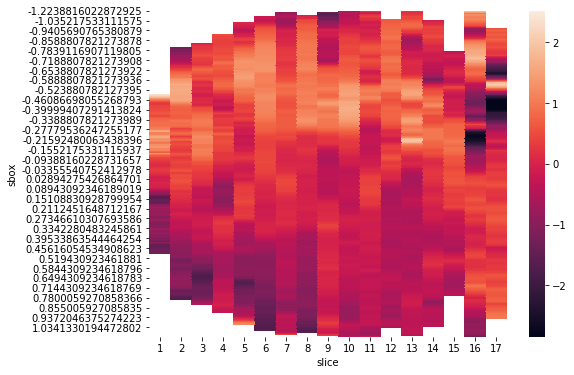

In [19]:
# NOTE HOW SLICES 16 and 17 are larger. 
# only one case had those slices, and the cortex is messy back there when you flip the medial wall (see original images/h5 file)
data_pivot = aa.pivot('sbox','slice','values')
#data_pivot.to_csv('mean_heatmap_p36_id2_sighted.csv')

plt.figure(figsize=(8, 6))
sns.heatmap(data_pivot)